# Buiding Height Estimation 

The objective of this assignment is to introduce you to the concept of autoencoders and
their use in building height estimation. The task involves utilizing single view and multi view
Google Earth Imagery to identify the height of buildings in 42 Chinese cities, comprising 4
municipalities, 26 provincial capitals, and 12 large cities. The focus is on urban areas of these
cities, which offer diverse buildings with varying colors, shapes, sizes, and height.
A dataset of 4394 training samples is provided, already split into 70%, 10%, and 20% for
train, validation, and test sets. The assignment requires you to create an autoencoder for
building height estimation, a regression task where appropriate losses must be utilized. The
goal is to achieve the lowest possible Root Mean Square Error (RMSE) in your model.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
DATASET_LINK = './drive/MyDrive/Colab Notebooks/datasets/Chinese Cities/Data'

In [17]:
!cp './drive/MyDrive/Colab Notebooks/datasets/Chinese Cities/Data' -d './Data'

In [18]:
REFERENCE_PAPER_LINK = 'https://www.sciencedirect.com/science/article/abs/pii/S0034425721003102'

## Imports

In [2]:
import os

import matplotlib.pyplot as plt

import torch
import torchvision
from tqdm.notebook import tqdm

from PIL import Image

from torch import nn
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset


## Load Dataset

To load the data, we will use a method that only loads files present in all four directories, namely view1, view2, mask, and seg. To accomplish this, we will take the intersection of all files in these folders, which will provide us with a pool of data.

In [3]:
class CreateDataset(Dataset):
    ''' Custom dataset that loads and returs view1, view2, seg and mask.'''
    def __init__(self, category='train', transform=None, target_transform=None):
        self.BASEDIR = './Data'
        self.FOLDER = f"{self.BASEDIR}/{category}"
        self.image_idx = os.listdir(f"{self.FOLDER}/view1")
        self.n_images = len(self.image_idx)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        image_name = self.image_idx[idx]
        # Load View 1, View 2, Mask and seg
        view1 = read_image(f"{self.FOLDER}/view1/{image_name}", mode=ImageReadMode.RGB) 
        view2 = read_image(f"{self.FOLDER}/view2/{image_name}", mode=ImageReadMode.RGB)
        seg = read_image(f"{self.FOLDER}/seg/{image_name}")
        mask = read_image(f"{self.FOLDER}/mask/{image_name}")

        if self.transform:
            view1 = self.transform(view1)
            view2 = self.transform(view2)
            seg = self.transform(seg)
            mask = self.transform(mask)

        if self.target_transform:
            mask = self.target_transform(mask)
        # Stack two images on top 
        return view1, view2, mask, seg 


In [19]:
# Initialize and create data loader
target_transforms = transforms.Grayscale()

dataset = CreateDataset(category='train', transform=None, target_transform=target_transforms)
dataloader = DataLoader(dataset)

## Data Visualization

In [20]:
images = view1, view2, mask, seg = next(iter(dataloader))

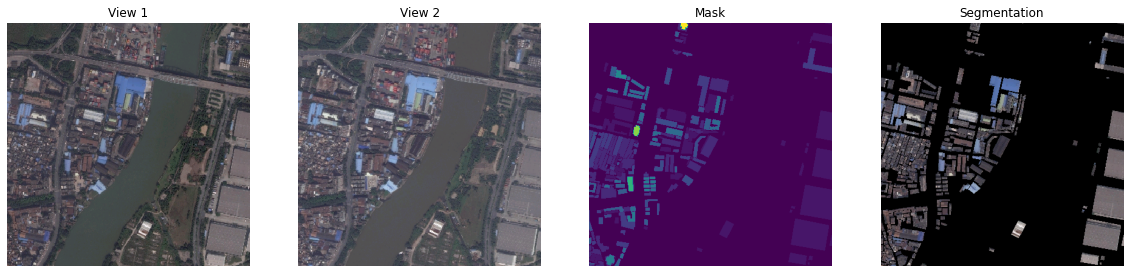

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20,20))

titles = ["View 1", "View 2", "Mask", "Segmentation"]
ax[0].axis(False)
ax[0].set_title(titles[0])
ax[0].imshow(view1.squeeze().permute(1,2,0))

ax[1].axis(False)
ax[1].set_title(titles[1])
ax[1].imshow(view2.squeeze().permute(1,2,0))

ax[2].axis(False)
ax[2].set_title(titles[2])
ax[2].imshow(mask.squeeze())

ax[3].axis(False)
ax[3].set_title(titles[3])
ax[3].imshow((seg * view1).squeeze().permute(1,2,0))
    
plt.show()

# Models

We need to create 4 autoencoder models 

1. Take a single image encode and decode and make height prediciton
2. Takes 2 images encode and decode make height prediction
3. Take a single image and encode and decode and make height and segmentation prediction
4. Takes 2 images encode and docode and make height and segmentation prediction

## Model 1

In [166]:
DEBUG = False

In [167]:
class SingleViewHeightEstimation(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=5, stride=2), 
            nn.BatchNorm2d(32),
            nn.ReLU(), 

            nn.Conv2d(32, 16, kernel_size=5, stride=2), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 

            nn.Conv2d(16, 8, kernel_size=5, stride=2), 

        )    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid(),
        )  

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [168]:
EPOCHS = 10
LEARNING_RATE = 3e-3
BATCH_SIZE = 32

if DEBUG:
    EPOCHS = 3
    BATCH_SIZE = 32

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

device_name = torch.cuda.get_device_name(0)
print(f"Setting compute device to {DEVICE} on {device_name}")

Setting compute device to cuda on Tesla T4


In [169]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, act):
        loss_fn = nn.MSELoss()
        loss = torch.sqrt(loss_fn(pred, act))

        return loss

In [170]:
torch.cuda.empty_cache()
model = SingleViewHeightEstimation().to(DEVICE)

In [171]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 141257


In [172]:
criterion = RMSELoss()
val_criterion = RMSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [173]:
# Load training dataset
dataset = CreateDataset(category='train', transform=None, target_transform=target_transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
print(f"Length of training dataset is: {len(dataloader) * BATCH_SIZE}")

# Load Validation dataset
val_dataset = CreateDataset(category='val', transform=None, target_transform=target_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
print(f"Length of Validation dataset is: {len(val_dataloader) * BATCH_SIZE}")

Length of training dataset is: 3104
Length of Validation dataset is: 448


In [174]:
loss_list = []
val_loss_list = []

In [175]:
for epoch in range(EPOCHS):
    for idx, (view1, _, mask, _) in tqdm(enumerate(dataloader), total=len(dataloader)):
        view1 = view1.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        pred = model(view1) # Model Output
        act = mask.to(torch.float32).to(DEVICE, non_blocking=True)
        loss = criterion(pred, act)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate the validation loss
    with torch.no_grad():
        for idx, (view1, _, mask, _) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            view1 = view1.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
            pred = model(view1) # Model Output
            act = mask.to(DEVICE, non_blocking=True)
            val_loss = val_criterion(pred, act)
            
    print(f"Epoch {epoch + 1 }: Training Loss {loss.item():.6f}, Validation Loss: {val_loss.item():.6f}")

    loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())



  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1: Training Loss 1.709831, Validation Loss: 2.812891


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2: Training Loss 1.694129, Validation Loss: 2.800590


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3: Training Loss 1.671172, Validation Loss: 2.795780


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4: Training Loss 1.655424, Validation Loss: 2.792678


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5: Training Loss 1.647389, Validation Loss: 2.790599


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6: Training Loss 1.638757, Validation Loss: 2.790127


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7: Training Loss 1.633129, Validation Loss: 2.789315


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8: Training Loss 1.633528, Validation Loss: 2.789057


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9: Training Loss 1.629653, Validation Loss: 2.788228


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10: Training Loss 1.625751, Validation Loss: 2.788461


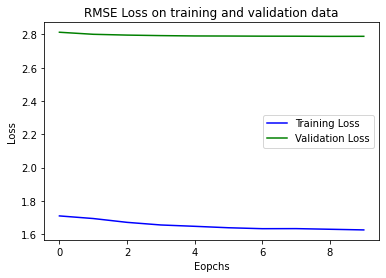

In [176]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("RMSE Loss on training and validation data")
plt.plot(loss_list, 'b', label="Training Loss")
plt.plot(val_loss_list, 'g', label="Validation Loss")
plt.legend()
plt.show()

In [177]:
# Load test dataset
test_dataset = CreateDataset(category='test', transform=None, target_transform=target_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Length of testing dataset is: {len(test_dataloader) * BATCH_SIZE}")


Length of testing dataset is: 896


In [178]:
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

In [179]:
# Testing on test data
total_rmse_loss = 0.0
total_mse_loss = 0.0
total_mae_loss = 0.0
batches = len(test_dataloader)

with torch.no_grad():
    for idx, (view1_img, _, mask, _) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        view1_img = view1_img.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        pred = model(view1_img) # Model Output
        act = mask.to(DEVICE, non_blocking=True)
        
        total_rmse_loss += criterion(pred, act)
        total_mse_loss += mse_loss(pred, act)
        total_mae_loss += mae_loss(pred, act)

    
    print(f"Test Loss: rMSE: {total_rmse_loss / batches:.6f} MSE {total_mse_loss / batches:.6f}, MAE: {total_mae_loss / batches:.6f}")

  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss: rMSE: 2.894819 MSE 8.463334, MAE: 1.137997


In [181]:
# Saving the model 
torch.save(model, "model1.pth")

## Model 2


In [182]:
DEBUG = False

In [183]:
class MultiViewHeightEstimation(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=5, stride=2), 
            nn.BatchNorm2d(32),
            nn.ReLU(), 

            nn.Conv2d(32, 16, kernel_size=5, stride=2), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 

            nn.Conv2d(16, 8, kernel_size=5, stride=2), 

        )   
        self.encoder2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=5, stride=2), 
            nn.BatchNorm2d(32),
            nn.ReLU(), 

            nn.Conv2d(32, 16, kernel_size=5, stride=2), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 

            nn.Conv2d(16, 8, kernel_size=5, stride=2), 

        )   
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid(),
        )  

    def forward(self, x1, x2):
        x1 = self.encoder1(x1)
        x2 = self.encoder2(x2)
        x = x1 + x2
        x = self.decoder(x)

        return x

In [184]:
EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

if DEBUG:
    EPOCHS = 3
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

device_name = torch.cuda.get_device_name(0)
print(f"Setting compute device to {DEVICE} on {device_name}")

Setting compute device to cuda on Tesla T4


In [185]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, act):
        loss_fn = nn.MSELoss()
        loss = torch.sqrt(loss_fn(pred, act))

        return loss

In [186]:
torch.cuda.empty_cache()
model = MultiViewHeightEstimation().to(DEVICE)

In [187]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 213601


In [188]:
criterion = RMSELoss()
val_criterion = RMSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [189]:
# Load training dataset
dataset = CreateDataset(category='train', transform=None, target_transform=target_transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
print(f"Length of training dataset is: {len(dataloader) * BATCH_SIZE}")

# Load Validation dataset
val_dataset = CreateDataset(category='val', transform=None, target_transform=target_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
print(f"Length of Validation dataset is: {len(val_dataloader) * BATCH_SIZE}")

Length of training dataset is: 3104
Length of Validation dataset is: 448


In [190]:
loss_list = []
val_loss_list = []

In [191]:
for epoch in range(EPOCHS):
    for idx, (view1, view2, mask, _) in tqdm(enumerate(dataloader), total=len(dataloader)):
        view1 = view1.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        view2 = view2.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        pred = model(view1, view2) # Model Output
        act = mask.to(torch.float32).to(DEVICE, non_blocking=True)
        loss = criterion(pred, act)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate the validation loss
    with torch.no_grad():
        for idx, (view1, view2, mask, _) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            view1 = view1.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
            view2 = view2.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
            pred = model(view1, view2) # Model Output
            act = mask.to(DEVICE, non_blocking=True)
            val_loss = val_criterion(pred, act)
            
    print(f"Epoch {epoch + 1 }: Training Loss {loss.item():.6f}, Validation Loss: {val_loss.item():.6f}")

    loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())



  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1: Training Loss 1.714453, Validation Loss: 2.815098


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2: Training Loss 1.691916, Validation Loss: 2.801768


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3: Training Loss 1.662363, Validation Loss: 2.791292


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4: Training Loss 1.643972, Validation Loss: 2.786175


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5: Training Loss 1.632154, Validation Loss: 2.783523


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6: Training Loss 1.621130, Validation Loss: 2.781843


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7: Training Loss 1.615673, Validation Loss: 2.780681


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8: Training Loss 1.613397, Validation Loss: 2.778988


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9: Training Loss 1.614359, Validation Loss: 2.779612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10: Training Loss 1.609409, Validation Loss: 2.778154


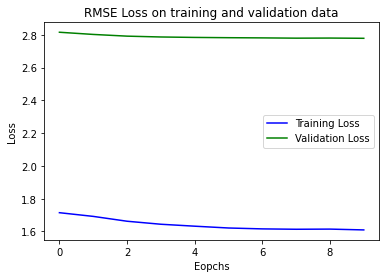

In [192]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("RMSE Loss on training and validation data")
plt.plot(loss_list, 'b', label="Training Loss")
plt.plot(val_loss_list, 'g', label="Validation Loss")
plt.legend()
plt.show()

In [193]:
# Load test dataset
test_dataset = CreateDataset(category='test', transform=None, target_transform=target_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Length of testing dataset is: {len(test_dataloader) * BATCH_SIZE}")


Length of testing dataset is: 896


In [194]:
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

In [195]:
# Testing on test data
total_rmse_loss = 0.0
total_mse_loss = 0.0
total_mae_loss = 0.0
batches = len(test_dataloader)

with torch.no_grad():
    for idx, (view1_img, view2_img, mask, _) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        view1_img = view1_img.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        view2_img = view2_img.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        pred = model(view1_img, view2_img) # Model Output
        act = mask.to(DEVICE, non_blocking=True) 
        
        total_rmse_loss += criterion(pred, act)
        total_mse_loss += mse_loss(pred, act)
        total_mae_loss += mae_loss(pred, act)

    
    print(f"Test Loss: rMSE: {total_rmse_loss / batches:.6f} MSE {total_mse_loss / batches:.6f}, MAE: {total_mae_loss / batches:.6f}")

  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss: rMSE: 2.901421 MSE 8.546227, MAE: 1.104573


In [197]:
# Saving the model 
torch.save(model, "model2.pth")

## Model 3

In [198]:
DEBUG = False

In [199]:
class SignleViewHandSEstimation(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=5, stride=2), 
            nn.BatchNorm2d(32),
            nn.ReLU(), 

            nn.Conv2d(32, 16, kernel_size=5, stride=2), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 

            nn.Conv2d(16, 8, kernel_size=5, stride=2), 

        )   
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid(),
        )  
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x1):
        x = self.encoder(x1)
        mask = self.decoder1(x)
        seg = self.decoder2(x)

        return mask, seg

In [200]:
EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

if DEBUG:
    EPOCHS = 3
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

device_name = torch.cuda.get_device_name(0)
print(f"Setting compute device to {DEVICE} on {device_name}")

Setting compute device to cuda on Tesla T4


In [201]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, act):
        loss_fn = nn.MSELoss()
        loss = torch.sqrt(loss_fn(pred, act))

        return loss

In [202]:
torch.cuda.empty_cache()
model = SignleViewHandSEstimation().to(DEVICE)

In [203]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 213372


In [204]:
criterion = RMSELoss()
val_criterion = RMSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [205]:
# Load training dataset
dataset = CreateDataset(category='train', transform=None, target_transform=target_transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
print(f"Length of training dataset is: {len(dataloader) * BATCH_SIZE}")

# Load Validation dataset
val_dataset = CreateDataset(category='val', transform=None, target_transform=target_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
print(f"Length of Validation dataset is: {len(val_dataloader) * BATCH_SIZE}")

Length of training dataset is: 3104
Length of Validation dataset is: 448


In [206]:
loss_list = []
val_loss_list = []

In [207]:
for epoch in range(EPOCHS):
    for idx, (view1, _, mask, seg) in tqdm(enumerate(dataloader), total=len(dataloader)):
        view1 = view1.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        act_mask = mask.to(torch.float32).to(DEVICE, non_blocking=True)
        act_seg = seg.to(torch.float32).to(DEVICE, non_blocking=True) * view1
        
        pred_mask, pred_seg = model(view1) # Model Output
        loss1 = criterion(pred_mask, act_mask)
        loss2 = criterion(pred_seg, act_seg)

        loss = loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate the validation loss
    with torch.no_grad():
        for idx, (view1, _, mask, seg) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            view1 = view1.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
            act_mask = mask.to(DEVICE, non_blocking=True)
            act_seg = seg.to(DEVICE, non_blocking=True) * view1
            pred_mask, pred_seg = model(view1) # Model Output
            

            val_loss1 = val_criterion(pred_mask, act_mask)
            val_loss2 = val_criterion(pred_seg, act_seg)

            val_loss = val_loss1 + val_loss2

            
    print(f"Epoch {epoch + 1 }: Training Loss {loss.item():.6f}, Validation Loss: {val_loss.item():.6f}")

    loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())



  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1: Training Loss 1.966540, Validation Loss: 3.058642


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2: Training Loss 1.932917, Validation Loss: 3.031315


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3: Training Loss 1.901061, Validation Loss: 3.006699


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4: Training Loss 1.871483, Validation Loss: 2.994701


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5: Training Loss 1.845235, Validation Loss: 2.986956


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6: Training Loss 1.831167, Validation Loss: 2.981831


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7: Training Loss 1.819884, Validation Loss: 2.978936


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8: Training Loss 1.809203, Validation Loss: 2.976354


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9: Training Loss 1.802770, Validation Loss: 2.975308


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10: Training Loss 1.795988, Validation Loss: 2.974887


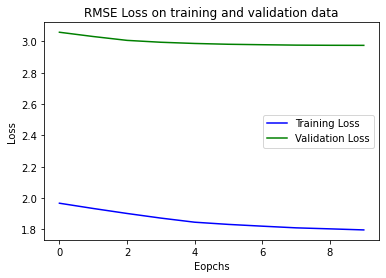

In [208]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("RMSE Loss on training and validation data")
plt.plot(loss_list, 'b', label="Training Loss")
plt.plot(val_loss_list, 'g', label="Validation Loss")
plt.legend()
plt.show()

In [209]:
# Load test dataset
test_dataset = CreateDataset(category='test', transform=None, target_transform=target_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Length of testing dataset is: {len(test_dataloader) * BATCH_SIZE}")


Length of testing dataset is: 896


In [210]:
mse_criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

In [211]:
# Testing on test data
total_rmse_loss = 0.0
total_mse_loss = 0.0
total_mae_loss = 0.0
batches = len(test_dataloader)

with torch.no_grad():
    for idx, (view1, _40, mask, seg) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        view1 = view1.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        act_mask = mask.to(DEVICE, non_blocking=True)
        act_seg = seg.to(DEVICE, non_blocking=True) * view1
        pred_mask, pred_seg = model(view1) # Model Output
        
        total_rmse_loss += criterion(pred_mask, act_mask) + criterion(pred_seg, act_seg)

        total_mse_loss += mse_criterion(pred_mask, act_mask) + mse_criterion(pred_seg, act_seg)

        total_mae_loss += mae_criterion(pred_mask, act_mask) + mae_criterion(pred_seg, act_seg)

    
    print(f"Test Loss: rMSE: {total_rmse_loss / batches:.6f} MSE {total_mse_loss / batches:.6f}, MAE: {total_mae_loss / batches:.6f}")

  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss: rMSE: 3.084612 MSE 8.542093, MAE: 1.273801


In [212]:
# Saving the model 
torch.save(model, "model3.pth")

## Model 4


In [213]:
DEBUG = False

In [214]:
class MultiViewHandSEstimation(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=5, stride=2), 
            nn.BatchNorm2d(32),
            nn.ReLU(), 

            nn.Conv2d(32, 16, kernel_size=5, stride=2), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 

            nn.Conv2d(16, 8, kernel_size=5, stride=2), 

        )   
        self.encoder2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=5, stride=2), 
            nn.BatchNorm2d(32),
            nn.ReLU(), 

            nn.Conv2d(32, 16, kernel_size=5, stride=2), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 

            nn.Conv2d(16, 8, kernel_size=5, stride=2), 

        )   
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid(),
        )  
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x1, x2):
        x1 = self.encoder1(x1)
        x2 = self.encoder2(x2)
        x = x1 + x2
        mask = self.decoder1(x)
        seg = self.decoder2(x)

        return mask, seg

In [215]:
EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

if DEBUG:
    EPOCHS = 3
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

device_name = torch.cuda.get_device_name(0)
print(f"Setting compute device to {DEVICE} on {device_name}")

Setting compute device to cuda on Tesla T4


In [216]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, act):
        loss_fn = nn.MSELoss()
        loss = torch.sqrt(loss_fn(pred, act))

        return loss

In [217]:
torch.cuda.empty_cache()
model = MultiViewHandSEstimation().to(DEVICE)

In [218]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 285716


In [219]:
criterion = RMSELoss()
val_criterion = RMSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [220]:
# Load training dataset
dataset = CreateDataset(category='train', transform=None, target_transform=target_transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
print(f"Length of training dataset is: {len(dataloader) * BATCH_SIZE}")

# Load Validation dataset
val_dataset = CreateDataset(category='val', transform=None, target_transform=target_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
print(f"Length of Validation dataset is: {len(val_dataloader) * BATCH_SIZE}")

Length of training dataset is: 3104
Length of Validation dataset is: 448


In [221]:
loss_list = []
val_loss_list = []

In [222]:
for epoch in range(EPOCHS):
    for idx, (view1, view2, mask, seg) in tqdm(enumerate(dataloader), total=len(dataloader)):
        view1 = view1.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        view2 = view2.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        act_mask = mask.to(torch.float32).to(DEVICE, non_blocking=True)
        act_seg = seg.to(torch.float32).to(DEVICE, non_blocking=True) * view1
        
        pred_mask, pred_seg = model(view1, view2) # Model Output
        loss1 = criterion(pred_mask, act_mask)
        loss2 = criterion(pred_seg, act_seg)

        loss = loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate the validation loss
    with torch.no_grad():
        for idx, (view1, view2, mask, seg) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            view1 = view1.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
            view2 = view2.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
            act_mask = mask.to(DEVICE, non_blocking=True)
            act_seg = seg.to(DEVICE, non_blocking=True) * view1
            pred_mask, pred_seg = model(view1, view2) # Model Output
            

            val_loss1 = val_criterion(pred_mask, act_mask)
            val_loss2 = val_criterion(pred_seg, act_seg)

            val_loss = val_loss1 + val_loss2

            
    print(f"Epoch {epoch + 1 }: Training Loss {loss.item():.6f}, Validation Loss: {val_loss.item():.6f}")

    loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())



  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1: Training Loss 1.967199, Validation Loss: 3.043599


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2: Training Loss 1.918973, Validation Loss: 3.011803


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3: Training Loss 1.890034, Validation Loss: 2.995374


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4: Training Loss 1.853273, Validation Loss: 2.981724


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5: Training Loss 1.830286, Validation Loss: 2.974385


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6: Training Loss 1.805456, Validation Loss: 2.968658


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7: Training Loss 1.793641, Validation Loss: 2.965028


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8: Training Loss 1.785874, Validation Loss: 2.963088


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9: Training Loss 1.779805, Validation Loss: 2.961973


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10: Training Loss 1.775451, Validation Loss: 2.960028


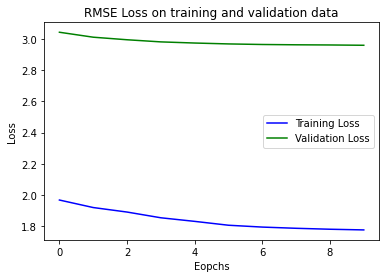

In [223]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("RMSE Loss on training and validation data")
plt.plot(loss_list, 'b', label="Training Loss")
plt.plot(val_loss_list, 'g', label="Validation Loss")
plt.legend()
plt.show()

In [224]:
# Load test dataset
test_dataset = CreateDataset(category='test', transform=None, target_transform=target_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Length of testing dataset is: {len(test_dataloader) * BATCH_SIZE}")


Length of testing dataset is: 896


In [225]:
mse_criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

In [226]:
# Testing on test data
total_rmse_loss = 0.0
total_mse_loss = 0.0
total_mae_loss = 0.0
batches = len(test_dataloader)

with torch.no_grad():
    for idx, (view1, view2, mask, seg) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        view1 = view1.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        view2 = view2.to(DEVICE, non_blocking=True) / 255 # Send batch images to compute device
        act_mask = mask.to(DEVICE, non_blocking=True)
        act_seg = seg.to(DEVICE, non_blocking=True) * view1
        pred_mask, pred_seg = model(view1, view2) # Model Output
        
        total_rmse_loss += criterion(pred_mask, act_mask) + criterion(pred_seg, act_seg)

        total_mse_loss += mse_criterion(pred_mask, act_mask) + mse_criterion(pred_seg, act_seg)

        total_mae_loss += mae_criterion(pred_mask, act_mask) + mae_criterion(pred_seg, act_seg)

    
    print(f"Test Loss: rMSE: {total_rmse_loss / batches:.6f} MSE {total_mse_loss / batches:.6f}, MAE: {total_mae_loss / batches:.6f}")

  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss: rMSE: 3.066781 MSE 8.466848, MAE: 1.228191


In [227]:
# Saving the model 
torch.save(model, "model4.pth")